# Chatbot Data Evaluation with Advanced Techniques and Visual Charts (No spaCy)

This Jupyter Notebook evaluates the Twitter Customer Service Dataset from Kaggle (https://www.kaggle.com/thoughtvector/customer-support-on-twitter) for a customer service chatbot in a trucking/fueling credit provider context. It focuses on **data evaluation** without model training, using advanced techniques to assess dataset suitability. To avoid conflicts with NumPy versions, it does not use spaCy, instead implementing rule-based entity extraction. The analysis includes:

- **Text Analysis**:
  - Keyword frequency to identify prevalent terms (e.g., 'card', 'fuel').
  - Sentiment analysis with TextBlob to gauge query tone (positive, negative, neutral).
  - Rule-based entity extraction for station names (e.g., 'Pilot Flying J') and monetary amounts (e.g., '$200').

- **Data Quality Metrics**:
  - Completeness: Proportion of non-missing tweets.
  - Relevance: Proportion of tweets relevant to trucking/fuel card queries.
  - Diversity: Distribution of simulated intents (e.g., 'check_balance', 'report_declined_card').

- **Visual Charts**:
  - Keyword frequency bar plot.
  - Sentiment distribution pie chart.
  - Entity distribution bar plot (STATION, MONEY).
  - Intent distribution bar plot.
  - Data quality metrics bar plot.
  - Tweet length distribution histogram.
  - Word cloud of frequent terms.

## Prerequisites
- Install libraries: `pip install pandas numpy nltk textblob wordcloud seaborn matplotlib`
- Download `twcs.csv` from Kaggle and place it in the same directory.
- Ensure ~500MB storage for the dataset.

## Outputs
- Test dataset: `trucking_chatbot_test_dataset.csv` with simulated intents and entities.
- Metrics: Data quality metrics printed to the console.
- Visualizations: Charts for text analysis and data quality.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set seaborn style for better visuals
sns.set_style('whitegrid')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nishe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nishe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Twitter Customer Service Dataset

Loads the dataset and filters for tweets relevant to trucking/fuel card queries using keywords like 'card', 'fuel', 'payment'.

In [2]:
def load_twitter_dataset(file_path='twcs.csv'):
    if not os.path.exists(file_path):
        print("Please download the Twitter Customer Service Dataset from Kaggle: https://www.kaggle.com/thoughtvector/customer-support-on-twitter")
        print("Place 'twcs.csv' in the same directory.")
        return None
    
    df = pd.read_csv(file_path)
    customer_tweets = df[df['inbound'] == True][['text']].dropna()
    keywords = ['card', 'balance', 'declined', 'payment', 'fuel', 'station', 'credit', 'transaction']
    customer_tweets['is_relevant'] = customer_tweets['text'].str.lower().str.contains('|'.join(keywords), na=False)
    relevant_tweets = customer_tweets[customer_tweets['is_relevant']][['text']].head(500)  # Limit to 500 for simplicity
    return relevant_tweets

## Create Test Dataset with Simulated Intents and Entities

Assigns simulated intents (e.g., 'check_balance') and extracts entities (e.g., station names, amounts) using rule-based methods.

In [3]:
def create_test_dataset(tweets_df):
    # Simulate intents
    intents = []
    for text in tweets_df['text']:
        text_lower = text.lower()
        if any(word in text_lower for word in ['balance', 'limit', 'how much']):
            intents.append('check_balance')
        elif any(word in text_lower for word in ['declined', 'not working', 'rejected']):
            intents.append('report_declined_card')
        elif any(word in text_lower for word in ['fuel', 'station', 'truck stop']):
            intents.append('find_fuel_station')
        else:
            intents.append('general_inquiry')
    tweets_df['intent'] = intents
    
    # Rule-based entity extraction
    stations = ['Pilot Flying J', 'Love\'s', 'TA/Petro', 'Flying J', 'Love’s Travel Stops']
    entities = []
    for text in tweets_df['text']:
        tweet_entities = []
        # Extract station names
        for station in stations:
            if station in text:
                tweet_entities.append((station, 'STATION'))
        # Extract monetary amounts
        money_matches = re.findall(r'\$\d+(?:\.\d{2})?|\d+\s*(?:dollars|usd)', text, re.IGNORECASE)
        for money in money_matches:
            tweet_entities.append((money, 'MONEY'))
        entities.append(tweet_entities)
    tweets_df['entities'] = entities
    
    return tweets_df

## Text Analysis

Performs keyword frequency analysis, sentiment analysis, and rule-based entity extraction to understand the dataset’s content.

In [4]:
def text_analysis(tweets_df):
    # Keyword frequency
    stop_words = set(stopwords.words('english'))
    all_words = []
    for text in tweets_df['text']:
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
        all_words.extend(tokens)
    keyword_freq = Counter(all_words)
    top_keywords = keyword_freq.most_common(10)
    
    # Sentiment analysis
    sentiments = []
    for text in tweets_df['text']:
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        if polarity > 0.1:
            sentiments.append('Positive')
        elif polarity < -0.1:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')
    sentiment_counts = Counter(sentiments)
    
    # Entity analysis
    entity_types = []
    for entities in tweets_df['entities']:
        entity_types.extend([ent[1] for ent in entities])
    entity_counts = Counter(entity_types)
    
    return {
        'keywords': top_keywords,
        'sentiments': sentiment_counts,
        'entities': entity_counts,
        'all_words': all_words
    }

## Data Quality Metrics

Calculates completeness, relevance, and diversity to assess dataset quality.

In [5]:
def data_quality_metrics(tweets_df, original_df):
    # Completeness: Proportion of non-missing tweets
    completeness = len(tweets_df) / len(original_df[original_df['inbound'] == True]) if len(original_df) > 0 else 0
    
    # Relevance: Proportion of relevant tweets (already filtered)
    relevance = 1.0  # All tweets in tweets_df are relevant by filtering
    
    # Diversity: Entropy of intent distribution
    intent_counts = tweets_df['intent'].value_counts()
    intent_probs = intent_counts / intent_counts.sum()
    diversity = -sum(p * np.log2(p) for p in intent_probs if p > 0) / np.log2(len(intent_counts)) if len(intent_counts) > 0 else 0
    
    print("\nData Quality Metrics:")
    print(f"Completeness: {completeness:.4f}")
    print(f"Relevance: {relevance:.4f}")
    print(f"Diversity (Normalized Entropy): {diversity:.4f}")
    
    return {
        'completeness': completeness,
        'relevance': relevance,
        'diversity': diversity,
        'intent_counts': intent_counts
    }

## Visualize Data Analysis

Creates charts for text analysis, data quality, and dataset characteristics.

In [6]:
def visualize_data(text_metrics, quality_metrics, tweets_df):
    # Keyword Frequency
    keywords_df = pd.DataFrame(text_metrics['keywords'], columns=['Keyword', 'Frequency'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frequency', y='Keyword', data=keywords_df, palette='Blues')
    plt.title('Top 10 Keywords in Trucking/Fuel Card Queries')
    plt.show()
    
    # Sentiment Distribution
    sentiment_df = pd.DataFrame.from_dict(text_metrics['sentiments'], orient='index', columns=['Count']).reset_index()
    sentiment_df['Percentage'] = sentiment_df['Count'] / sentiment_df['Count'].sum() * 100
    plt.figure(figsize=(7, 7))
    plt.pie(sentiment_df['Percentage'], labels=sentiment_df['index'], autopct='%1.1f%%', colors=sns.color_palette('Pastel1'))
    plt.title('Sentiment Distribution of Queries')
    plt.show()
    
    # Entity Distribution
    entity_df = pd.DataFrame.from_dict(text_metrics['entities'], orient='index', columns=['Count']).reset_index()
    entity_df = entity_df.rename(columns={'index': 'Entity Type'})
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Count', y='Entity Type', data=entity_df, palette='Greens')
    plt.title('Entity Type Distribution')
    for i, v in enumerate(entity_df['Count']):
        plt.text(v + 0.1, i, f'{v}', va='center')
    plt.show()
    
    # Intent Distribution
    intent_df = quality_metrics['intent_counts'].reset_index()
    intent_df.columns = ['Intent', 'Count']
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Count', y='Intent', data=intent_df, palette='Oranges')
    plt.title('Simulated Intent Distribution')
    for i, v in enumerate(intent_df['Count']):
        plt.text(v + 0.1, i, f'{v}', va='center')
    plt.show()
    
    # Data Quality Metrics
    quality_df = pd.DataFrame({
        'Metric': ['Completeness', 'Relevance', 'Diversity'],
        'Value': [quality_metrics['completeness'], quality_metrics['relevance'], quality_metrics['diversity']]
    })
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Value', y='Metric', data=quality_df, palette='Purples')
    plt.title('Data Quality Metrics')
    plt.xlim(0, 1)
    for i, v in enumerate(quality_df['Value']):
        plt.text(v + 0.01, i, f'{v:.4f}', va='center')
    plt.show()
    
    # Tweet Length Distribution
    tweet_lengths = tweets_df['text'].apply(len)
    plt.figure(figsize=(8, 5))
    sns.histplot(tweet_lengths, bins=30, color='teal')
    plt.xlabel('Tweet Length (Characters)')
    plt.title('Tweet Length Distribution')
    plt.show()
    
    # Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_metrics['all_words']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Trucking/Fuel Card Queries')
    plt.show()

## Run the Evaluation

Loads the dataset, creates the test dataset, performs text analysis and data quality evaluation, and visualizes results.

Test dataset saved as 'trucking_chatbot_test_dataset.csv'

Performing Text Analysis...

Evaluating Data Quality...

Data Quality Metrics:
Completeness: 0.0003
Relevance: 1.0000
Diversity (Normalized Entropy): 0.6516

Visualizing Data Analysis...


C:\Users\nishe\AppData\Local\Temp\ipykernel_27264\224903044.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=keywords_df, palette='Blues')


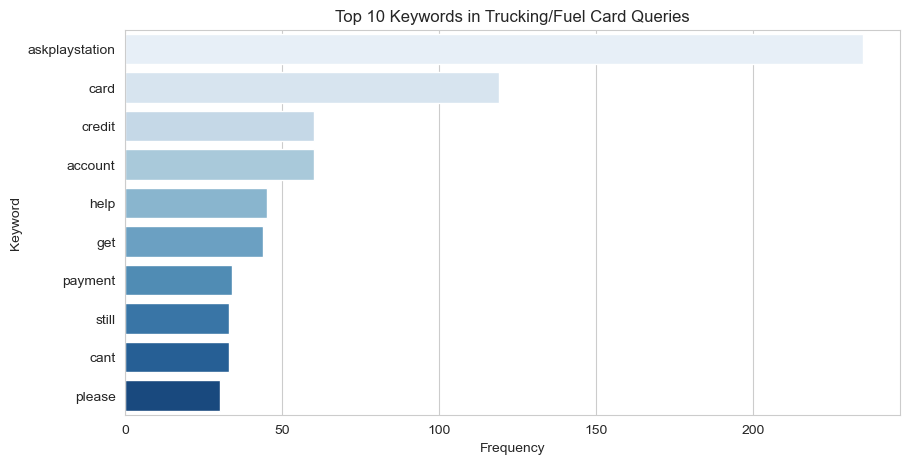

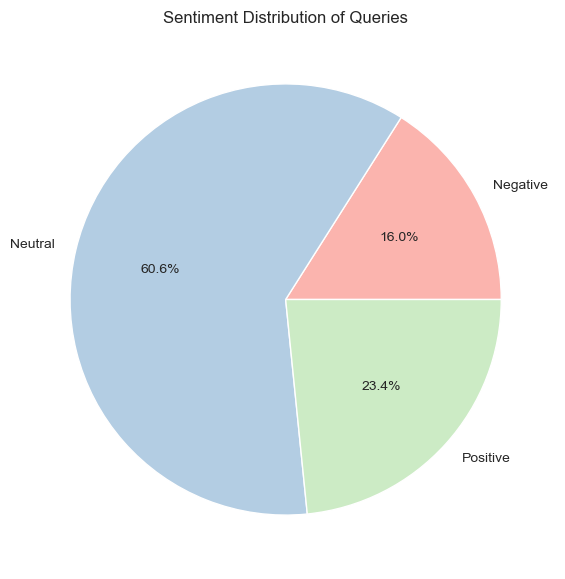

C:\Users\nishe\AppData\Local\Temp\ipykernel_27264\224903044.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Entity Type', data=entity_df, palette='Greens')


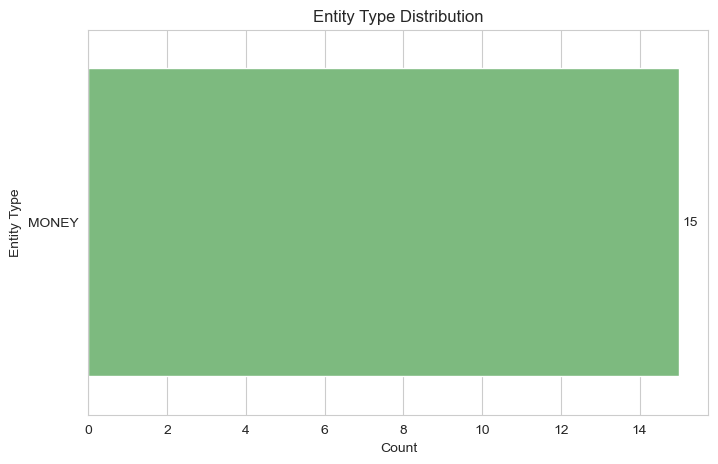

C:\Users\nishe\AppData\Local\Temp\ipykernel_27264\224903044.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Intent', data=intent_df, palette='Oranges')


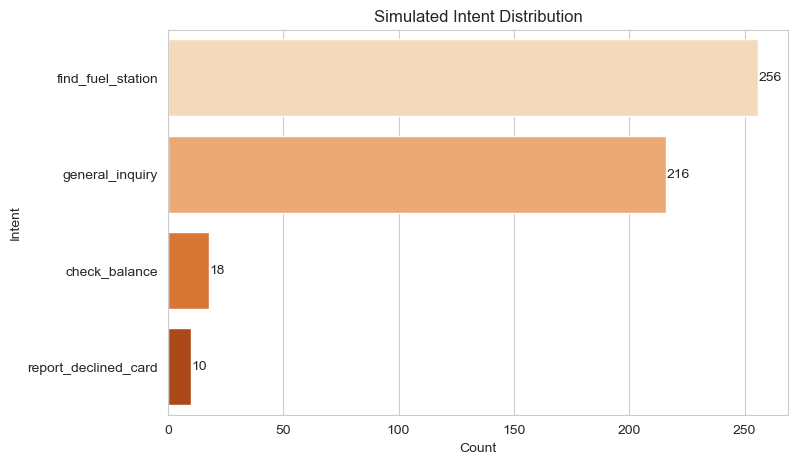

C:\Users\nishe\AppData\Local\Temp\ipykernel_27264\224903044.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Value', y='Metric', data=quality_df, palette='Purples')


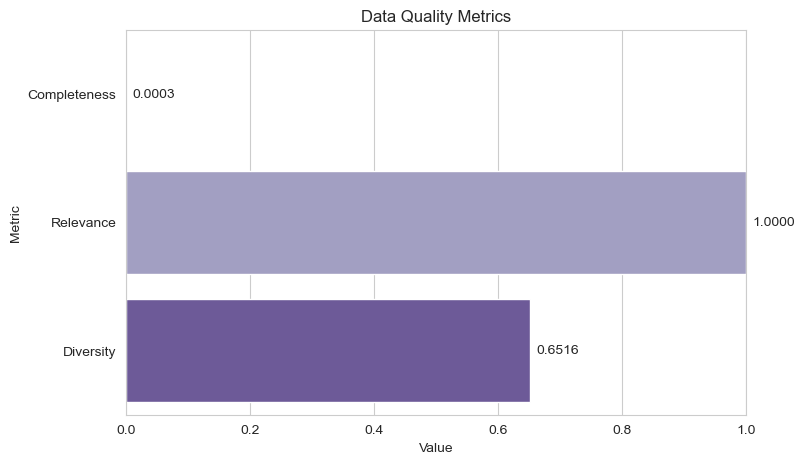

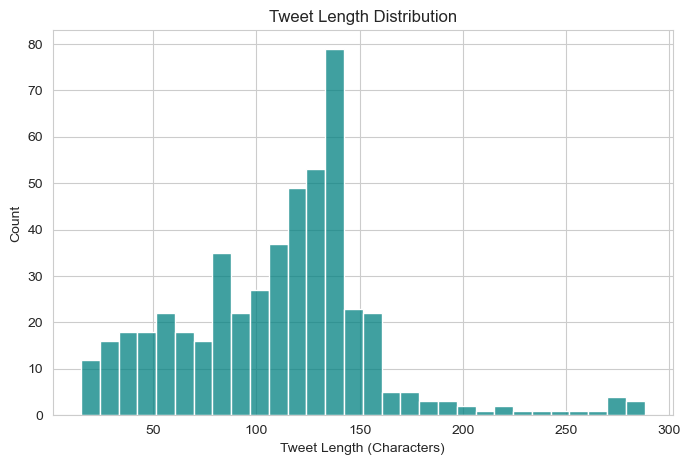

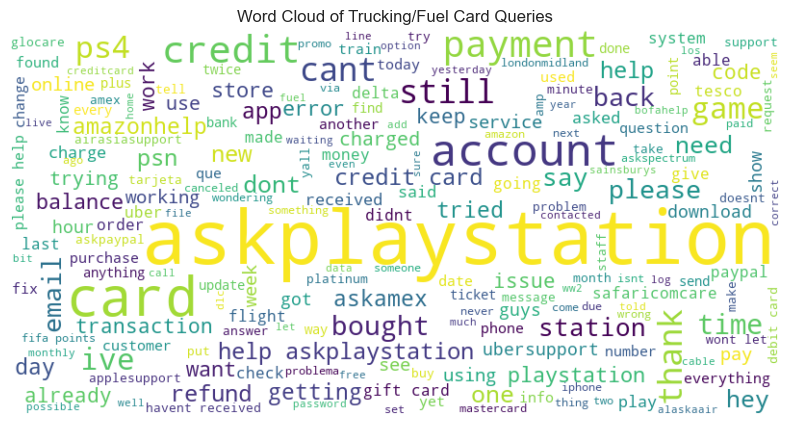

In [7]:
# Load dataset
original_df = pd.read_csv('twcs.csv') if os.path.exists('twcs.csv') else None
tweets_df = load_twitter_dataset()

if tweets_df is not None:
    # Create test dataset
    test_dataset = create_test_dataset(tweets_df)
    
    # Save test dataset
    test_dataset.to_csv('trucking_chatbot_test_dataset.csv', index=False)
    print("Test dataset saved as 'trucking_chatbot_test_dataset.csv'")
    
    # Perform text analysis
    print("\nPerforming Text Analysis...")
    text_metrics = text_analysis(test_dataset)
    
    # Evaluate data quality
    print("\nEvaluating Data Quality...")
    quality_metrics = data_quality_metrics(test_dataset, original_df)
    
    # Visualize results
    print("\nVisualizing Data Analysis...")
    visualize_data(text_metrics, quality_metrics, test_dataset)

## Next Steps

- Inspect `trucking_chatbot_test_dataset.csv` to verify intents and entities.
- Use the dataset for **chatbot training (e.g., Rasa, Dialogflow)** after manual intent/entity labeling.
- Enhance analysis with topic modeling (e.g., LDA) to identify query clusters.
- Add more keywords (e.g., 'Comdata', 'IFTA') or station names (e.g., 'Speedway') to improve relevance and entity extraction.
- Expand visualizations (e.g., entity co-occurrence, sentiment vs. intent).